# k-Nearest Neighbor (kNN) exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the course website.*

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

In [3]:
# Run some setup code for this notebook.

import random
import numpy as np
from comp451.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [4]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'comp451/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


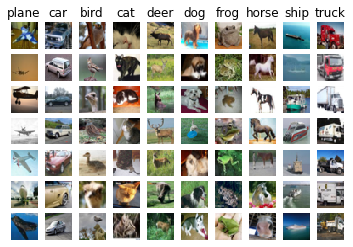

In [5]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [6]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [7]:
from comp451.classifiers import KNearestNeighbor

# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

**Note: For the three distance computations that we require you to implement in this notebook, you may not use the np.linalg.norm() function that numpy provides.**

First, open `comp451/classifiers/k_nearest_neighbor.py` and implement the function `compute_L2_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [6]:
# Open comp451/classifiers/k_nearest_neighbor.py and implement
# compute_L2_distances_two_loops and compute_L1_distances_two_loops.

# Test your implementation:
dists = classifier.compute_L2_distances_two_loops(X_test)
dists_L1 = classifier.compute_L1_distances_two_loops(X_test)
print(dists.shape)
print(dists_L1.shape)

(500, 5000)
(500, 5000)


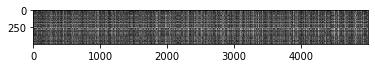

In [7]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

**Inline Question 1** 

Notice the structured patterns in the distance matrix, where some rows or columns are visible brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

$\color{blue}{\textit Your Answer:}$ 

- First of all, a bright row means that our test image looks similar to most of the training images, this could be due to various reasons: most notable would be that the background colors are perhaps similar, or the object colors are similar. This is something important to note, as our instructor pointed out that in one example the classifier was supposed to classify wolves, but turns out every training image of a wolf had white background. This could have resulted in the classifier to classify a car with white background as a wolf. Note that a dark row indicates the opposite: the test images looks nothing like any of the training images.

- Similar to the previous answer, a bright column indicates that the training image looks much like the test images, hence the bright row which indicates high similarity, or the opposite where a dark column is formed due to low similarity. Similarity is commutative, therefore the reason for this is as same as the one before, perhaps similar colorings, similar backgrounds, etc.




In [8]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [9]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


You should expect to see a slightly better performance than with `k = 1`.

**Inline Question 2**

We can also use other distance metrics such as L1 distance.
For pixel values $p_{ij}^{(k)}$ at location $(i,j)$ of some image $I_k$, 

the mean $\mu$ across all pixels over all images is $$\mu=\frac{1}{nhw}\sum_{k=1}^n\sum_{i=1}^{h}\sum_{j=1}^{w}p_{ij}^{(k)}$$
And the pixel-wise mean $\mu_{ij}$ across all images is 
$$\mu_{ij}=\frac{1}{n}\sum_{k=1}^np_{ij}^{(k)}.$$
The general standard deviation $\sigma$ and pixel-wise standard deviation $\sigma_{ij}$ is defined similarly.

Which of the following preprocessing steps will not change the performance of a Nearest Neighbor classifier that uses L1 distance? Select all that apply.
1. Subtracting the mean $\mu$ ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu$.)
2. Subtracting the per pixel mean $\mu_{ij}$  ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu_{ij}$.)
3. Subtracting the mean $\mu$ and dividing by the standard deviation $\sigma$.
4. Subtracting the pixel-wise mean $\mu_{ij}$ and dividing by the pixel-wise standard deviation $\sigma_{ij}$.
5. Rotating the coordinate axes of the data.

$\color{blue}{\textit Your Answer:}$
1, 2, 3, 4, 5

$\color{blue}{\textit Your Explanation:}$
1. The mean $\mu$ is calculated using all images, therefore when applied to the pixel values it will not matter for L1 distance, check the math: $|(p_{ij}^{(k)}-\mu) - (p_{ij}^{(l)}-\mu)| = |p_{ij}^{(k)} - p_{ij}^{(l)}|$. **The performance would not change for the classifier.**
2. This would also not matter for the performance, here is the reason using mathematics: $|(p_{ij}^{(k)}-\mu_{ij}) - (p_{ij}^{(l)}-\mu_{ij})| = |p_{ij}^{(k)} - p_{ij}^{(l)}|$. We are saved by the fact that we check distances pixel by pixel. **The performance would not change for the classifier.**
3. This is known as standardization in statistics. Again let us check the math: 
$$
\left|\frac{(p_{ij}^{(k)}-\mu)}{\sigma} - \frac{(p_{ij}^{(l)}-\mu)}{\sigma}\right| = \left|\frac{p_{ij}^{(k)} - p_{ij}^{(l)}}{\sigma}\right|
$$
Since standart deviation is never negative, we can take it outside of the absolute value, the distance between images $k$ and $l$ would be:
$$
\sum_{i=1}^{h}\sum_{j=1}^{w}\frac{\left|p_{ij}^{(k)} - p_{ij}^{(l)}\right|}{\sigma} = \frac{1}{\sigma}\sum_{i=1}^{h}\sum_{j=1}^{w}\left|p_{ij}^{(k)} - p_{ij}^{(l)}\right|
$$
This new distance is directly proportional to the distance without the preprocessing. By dividing with standart deviation we do not alter the behaviour of neighbor distances, thus, **the performance would not change for the classifier.**
4. Similar to the math we did in the previous case, the distance between images $k$ and $l$ become:
$$
\sum_{i=1}^{h}\sum_{j=1}^{w}\frac{\left|p_{ij}^{(k)} - p_{ij}^{(l)}\right|}{\sigma_{ij}}
$$
We can think this way, the new value of pixel difference is directly proportional to the pixel difference without dividing pixel-wise standart deviation. Therefore the neighbor distances would all show the same behaviour among themselves. **The performance would not change for the classifier.**
5. Notice how the sums below are equal:
$$
\sum_{i=1}^{h}\sum_{j=1}^{w}|p_{ij}^{(k)} - p_{ij}^{(l)}| = \sum_{j=1}^{w}\sum_{i=1}^{h}|p_{ji}^{(k)} - p_{ji}^{(l)}|
$$
We can infer that **the performance would not change for the classifier.**


In [10]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_L2_distances_one_loop and 
# compute_L1_distances_one_loop and run the code below:
dists_one = classifier.compute_L2_distances_one_loop(X_test)
dists_one_L1 = classifier.compute_L1_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('One loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')
    
difference = np.linalg.norm(dists_L1 - dists_one_L1, ord='fro')
print('One loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

One loop difference was: 0.000000
Good! The distance matrices are the same
One loop difference was: 0.000000
Good! The distance matrices are the same


In [11]:
# Now implement the fully vectorized version inside compute_L2_distances_no_loops
# and compute_L1_distances_no_loops and run the code
dists_two = classifier.compute_L2_distances_no_loops(X_test)
dists_two_L1 = classifier.compute_L1_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('No loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')
    
# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists_L1 - dists_two_L1, ord='fro')
print('No loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

No loop difference was: 0.000000
Good! The distance matrices are the same
No loop difference was: 366584605.652498
Uh-oh! The distance matrices are different


In [12]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_L2_distances_two_loops, X_test)
print('L2 two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_L2_distances_one_loop, X_test)
print('L2 one loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_L2_distances_no_loops, X_test)
print('L2 no loop version took %f seconds' % no_loop_time)

two_loop_time = time_function(classifier.compute_L1_distances_two_loops, X_test)
print('L1 two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_L1_distances_one_loop, X_test)
print('L1 one loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_L1_distances_no_loops, X_test)
print('L1 no loop version took %f seconds' % no_loop_time)

# You should see significantly faster performance with the fully vectorized implementation!

# NOTE: depending on what machine you're using, 
# you might not see a speedup when you go from two loops to one loop, 
# and might even see a slow-down.

L2 two loop version took 430.806566 seconds
L2 one loop version took 484.255993 seconds
L2 no loop version took 0.619872 seconds
L1 two loop version took 45.828481 seconds
L1 one loop version took 106.674431 seconds
L1 no loop version took 0.000996 seconds


### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation. Check which distance function (L1 or L2) performs better as well. Try each distance function for each k value.

In [15]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]
dist_fns = ['L1', 'L2']

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}


################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary. Do not forget to try each k   #
# for different distance functions.                                            #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
k_to_accuraciesL1 = {}
useNoLoops = False
# Note to instructor: Since L1 gave memory errors, we can not use noloop version. Two loop version is faster than one loop version,
# so it is possible to run this using two loops. However, it takes too much time, to run it using two loops, so I have this boolean
# here to decide whether to use L2 no loops or L1 two loops and L2 two loops.
# If we decide to use loop, (when useNoLoops = False) we take only a part of data so it doesnt take too long, and this will result 
# in a slight different graph, but we still get %28.2 accuracy so that is above %28.
for k in k_choices:
    k_to_accuracies[k] = []
    k_to_accuraciesL1[k] = []
    for d in dist_fns:
        for fold in range(num_folds):
            #print('Fold ',fold, '\tDist ',d,'\tK ',k)
            # vstack = vertical stack
            X_train_crossval = np.vstack(X_train_folds[0:fold]+ X_train_folds[fold+1:]) # choosing all but one as training
            X_test_crossval = X_train_folds[fold] # choosing one as test

            # hstack = horizontal stack
            y_train_crossval = np.hstack(y_train_folds[0:fold] + y_train_folds[fold+1:])
            y_test_crossval = y_train_folds[fold]

             # We will take only a part of data in hand so that looped version is faster
            # If there are N folds, train has (N-1)X data and test has X data. We take 1/10 of it.
            if not useNoLoops:
                maskTest = range(int(len(y_test_crossval)/10))
                maskTrain = range((num_folds-1)*int(len(y_test_crossval)/10))
                X_train_crossval = X_train_crossval[maskTrain]               
                y_train_crossval = y_train_crossval[maskTrain]
                X_test_crossval = X_test_crossval[maskTest]
                y_test_crossval = y_test_crossval[maskTest]
                
            classifier.train(X_train_crossval, y_train_crossval)
            
            # We do not implement L1 no loop, and one loop takes longer than two loops, so I chose two loop implementations to compare
            if d == 'L1':
                if useNoLoops:
                    dists_crossval = classifier.compute_L2_distances_no_loops(X_test_crossval) # use L2 instead of L1
                else:
                    dists_crossval = classifier.compute_L1_distances_two_loops(X_test_crossval)
            else:
                if useNoLoops:
                    dists_crossval = classifier.compute_L2_distances_no_loops(X_test_crossval)
                else:
                    dists_crossval = classifier.compute_L2_distances_two_loops(X_test_crossval)
            
            y_test_pred = classifier.predict_labels(dists_crossval, k)
            num_correct = np.sum(y_test_pred == y_test_crossval)
            accuracy = float(num_correct) / len(y_test_crossval)

            if d == 'L1':
                k_to_accuraciesL1[k].append(accuracy)
            else:
                k_to_accuracies[k].append(accuracy)
            

# Print out the computed accuracies
print("\n\nL1:")
for k in sorted(k_to_accuraciesL1):
        for accuracy in k_to_accuraciesL1[k]:
            print('k = %d, accuracy = %f' % (k, accuracy))
    
     
print("\n\nL2:")
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
        for accuracy in k_to_accuracies[k]:
            print('k = %d, accuracy = %f' % (k, accuracy))



L1:
k = 1, accuracy = 0.130000
k = 1, accuracy = 0.220000
k = 1, accuracy = 0.190000
k = 1, accuracy = 0.340000
k = 1, accuracy = 0.210000
k = 3, accuracy = 0.170000
k = 3, accuracy = 0.220000
k = 3, accuracy = 0.190000
k = 3, accuracy = 0.300000
k = 3, accuracy = 0.220000
k = 5, accuracy = 0.190000
k = 5, accuracy = 0.210000
k = 5, accuracy = 0.170000
k = 5, accuracy = 0.300000
k = 5, accuracy = 0.240000
k = 8, accuracy = 0.150000
k = 8, accuracy = 0.190000
k = 8, accuracy = 0.180000
k = 8, accuracy = 0.290000
k = 8, accuracy = 0.220000
k = 10, accuracy = 0.150000
k = 10, accuracy = 0.170000
k = 10, accuracy = 0.190000
k = 10, accuracy = 0.270000
k = 10, accuracy = 0.200000
k = 12, accuracy = 0.140000
k = 12, accuracy = 0.200000
k = 12, accuracy = 0.160000
k = 12, accuracy = 0.240000
k = 12, accuracy = 0.160000
k = 15, accuracy = 0.130000
k = 15, accuracy = 0.180000
k = 15, accuracy = 0.190000
k = 15, accuracy = 0.230000
k = 15, accuracy = 0.190000
k = 20, accuracy = 0.170000
k = 20

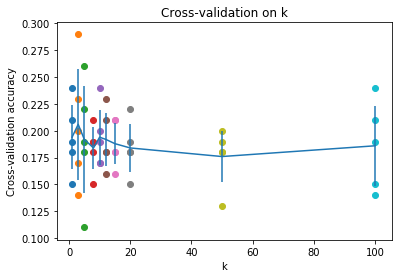

In [16]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k] # show L2 only
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [17]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 10

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 141 / 500 correct => accuracy: 0.282000


**Inline Question 3**

Which of the following statements about $k$-Nearest Neighbor ($k$-NN) are true in a classification setting, and for all $k$? Select all that apply.
1. The decision boundary of the k-NN classifier is linear.
2. The training error of a 1-NN will always be lower than that of 5-NN.
3. The test error of a 1-NN will always be lower than that of a 5-NN.
4. The time needed to classify a test example with the k-NN classifier grows with the size of the training set.
5. None of the above.

$\color{blue}{\textit Your Answer:}$ 2, 4


$\color{blue}{\textit Your Explanation:}$
1. No. Infact, the decision boundaries are pretty nonlinear and curvy, because we create the boundary based on points and their distances to each other, rather than creating a model or line etc. 

2. Yes. Training error of 1-NN is always 0, because the closest neighbor of a training point in training dataset is itself.

3. No. We could have a dataset where we misclassify a data point with 1-NN, of whom we would classify correctly using 5-NN.

4. Yes. It's because we want the shortest distance between points to find neighbors, and this requires a distance calculation between our testing point and all the trained points, therefore if the number of trained points increase this process will take longer.

5. Doesn't require explanation.